In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions_AMSR2 import forward_OIB_AMSR2
from prepare_inputs_OE_AMSR2 import prepare_inputs_FYI_AMSR2 as piO
from prepare_inputs_OE import OIB_data

In [2]:
def corrMat(self, data):
    ## Make correlation matrix - input covariance matrix
    corrMat = np.zeros(data.shape)
    sigmas = np.diag(data)**(1/2)
    rows = range(data.shape[0])
    cols = range(data.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(data)[row][col]/(sigma1*sigma2)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(data.keys())), labels=data.keys())
    ax.set_yticks(np.arange(len(data.keys())), labels=data.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(data.keys())):
        for j in range(len(data.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output correlation matrix')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(V_sens) + '_CorrOut.png' )
    plt.show()
    
def covMat(self, data, title):
    for var in self.x_vars:
        print(var)
        data[var][var] = data[var][var]**(1/2)
    ## get std
    try:
       data['lex']['lex'] = data['lex']['lex']*1e1
    except:
        pass
    try:
        data['sal']['sal'] = data['sal']['sal']*1e1
    except:
        pass
    try:
        data['rho']['rho'] = data['rho']['rho']*1e-2
    except:
        pass
    try:
        data['Tsur']['Tsur'] = data['Tsur']['Tsur']/1e2
    except:
        pass
    try:
        data['slope']['slope'] = data['slope']['slope']/1e2
    except:
        pass
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data*1e2,
        annot=True, 
        fmt='.2f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [cm,mm,kg/m3,PSU,'']'}
        # cbar_kws={'label':'Modified Covariance [log10(cm),log10(mm),log10(PSU),cm]'}
    )
    ax.set_title(title)
    if 'out' in title:
        plt.savefig(savepath  + '_CovOut.png' )
    else:
        plt.savefig(savepath  +'_CovIn.png' )
    plt.show()
def makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB):
    nl_snow = 3
    forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                     "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
    oe = pyOE.optimalEstimation(
    x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
    ,forwardKwArgs=forwardKwArgs
    ,x_lowerLimit=x_lowerLimit
    ,x_upperLimit=x_upperLimit
    )
    return oe
def calc_ang(var1, var2):
    
    text_file = open(savepath + "angles_jacobian.txt", "a")
    
    J = oe.getJacobian(oe.x_op, oe.y_op)[0]
    print('--------------------------------------------------')
    text_file.write('--------------------------------------------------\n')
    
    denominator = np.linalg.norm(J['perturbed '+var1][:5])*np.linalg.norm(J['perturbed '+var2][:5])
    nominator = np.dot(J['perturbed '+var1][:5], J['perturbed '+var2][:5])
    print('Angle between '+var1+' and '+var2+' vector V:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector V:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')

    
    denominator = np.linalg.norm(J['perturbed '+var1][5:])*np.linalg.norm(J['perturbed '+var2][5:])
    nominator = np.dot(J['perturbed '+var1][5:], J['perturbed '+var2][5:])
    print('Angle between '+var1+' and '+var2+ ' vector H:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector H:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')
    
def covOutMat(oe1, oe2):
    data=oe1/oe2
    f, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(
        data,
        cmap="rocket_r",
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.08,
        cbar=False,
        cbar_kws={"shrink": 0.5, 'label':'Ratio of covariance compared to input'}
    )
    ax.set_title('Fraction of input variance')
    plt.savefig(savepath + 'CovRatioOuttoIn.png' )
    plt.show()

In [3]:
FYI_data = OIB_data('FYI', new=True)
logarithmic = True
if logarithmic ==True:
    FYI_data.sd = np.log10(np.sum(FYI_data.sd, axis=1))
    FYI_data.sd_lex = np.log10(np.mean(FYI_data.sd_lex, axis=1))
else:
    FYI_data.sd = np.sum(FYI_data.sd, axis=1)
    FYI_data.sd_lex = np.mean(FYI_data.sd_lex, axis=1)
    # FYI_data.sd_sal = np.log10(np.sum(FYI_data.sd_sal, axis=1))
# FYI_sim_TB_mean = np.concatenate(([[TbV, TbH] for TbV, TbH in zip(FYI_data.TbV_sim, FYI_data.TbH_sim)]))
print(np.mean(FYI_data.TbV_sim, axis=0))
# print(FYI_data.TbH_sim)
FYI_OIB_AMSR = np.concatenate([np.mean(FYI_data.TbV_AMSR_all, axis=0), np.mean(FYI_data.TbH_AMSR_all, axis=0)])
FYI_OIB_AMSR_std = np.concatenate([np.std(FYI_data.TbV_AMSR_all, axis=0), np.std(FYI_data.TbH_AMSR_all, axis=0)])

[252.40565629 252.69556313 253.07707059 252.99794424 249.06426123]


In [4]:
# Saving location
# savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Only V/know_SIT/'
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Report_figures/'


# Numebr of layers
nl_snow = 3
# Polarization (V or both)
polarization = 'V'
# sensitivity of TBs (std)
V_sens = 0.5 # K
H_sens = 1.5 # K
# List with input variables
x_vars = ["SD", "lex", "rho", "sal", "Tsur", "SIT", "slope"]
## list with true values
# print(FYI_data.sd)
x_truth = [np.mean(FYI_data.sd),
           np.mean(FYI_data.sd_lex),
           np.mean(FYI_data.sd_rho),
           np.mean(np.sum(FYI_data.sd_sal, axis=1)),
           np.mean(FYI_data.skt),
           np.mean(FYI_data.sit),
           0.19]

print(x_truth)

[-0.8962165574900633, -3.670602120638958, 302.5, 0.00401, 253.0837746478873, 1.4398281690140846, 0.19]


[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]


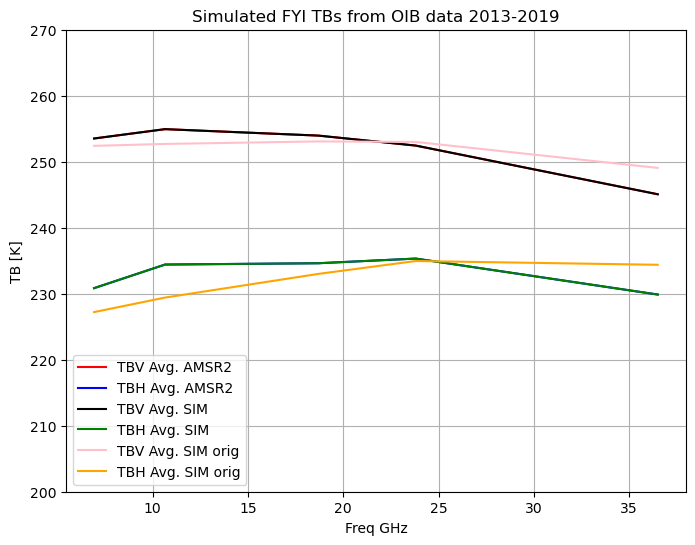

In [5]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]
# x_vars = ["SD", "lex", "rho", "sal",  "SIT", "slope"]
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=3)
print(x_ap)
# x_ap[-1]=0.19
data = forward_OIB_AMSR2(X=x_ap,self=FYI_data,variables=x_vars, nl_snow = nl_snow, n=0, pol='both', logarithmic=True, avg=True, sim=False)

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = data[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = data[5:]
plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
y = np.mean(FYI_data.TbV_sim, axis=0)
plt.plot(freqs, y, c='pink', label = 'TBV Avg. SIM orig')
y = np.mean(FYI_data.TbH_sim, axis=0)
plt.plot(freqs, y, c='orange', label = 'TBH Avg. SIM orig')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]


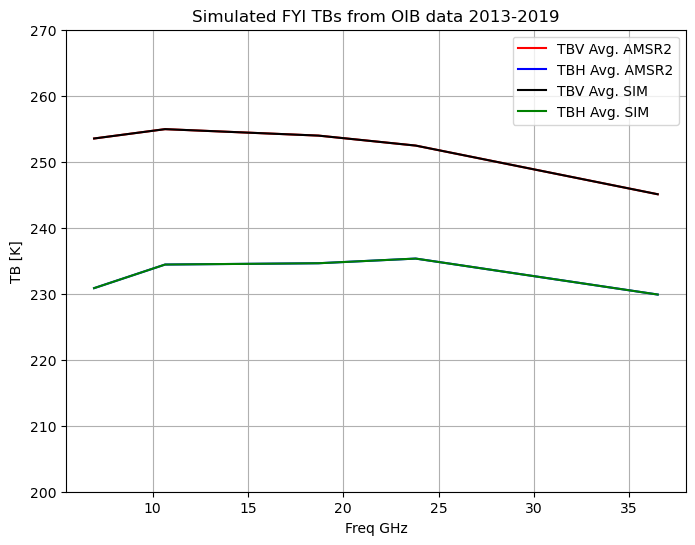

In [6]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]
# x_vars = ["SD", "SIT", "slope"]
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
print(x_ap)
data = forward_OIB_AMSR2(X=x_ap,self=FYI_data,variables=x_vars, nl_snow = nl_snow, n=0, pol='both', logarithmic=True, avg=True, sim=False)

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = data[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
y = data[5:]
plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

In [7]:
Bias = FYI_OIB_AMSR - data
print(Bias)

[-1.18447474e-09  2.06972572e-09 -4.88239493e-09 -1.05248432e-09
 -3.45193030e-09 -4.94409846e-09 -3.12468273e-10  4.71965222e-09
  8.91020591e-11  3.05379899e-09]


### Choose looking at only V or at both

### Choose how many input variables 

### choose Sy sensitivity

In [8]:
## Define name of y-variables
if polarization=='both':
    y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"]
    y_obs  = FYI_OIB_AMSR
    V_sens = np.array([0.3, 0.3, 0.6, 1.1, 1.1])+0.2
    H_sens = np.array([0.3, 0.3, 0.6, 1.1, 1.1])+0.5
    y_cov = np.diag(np.array([0.3, 0.3, 0.6, 1.1, 1.1] + [0.3, 0.3, 0.6, 1.1, 1.1])**2)
    y_cov = np.diag(np.concatenate((V_sens**2, H_sens**2)))
    # y_cov = np.diag(np.array([ 0.79518149 , 1.95518354,  0.78687942, -0.44976116, -1.73411494  ] + [ 2.12858105, 3.72325291,  0.72247579, -0.28446336, -3.19752185])**2)
elif polarization=='V':
    y_vars = ["6V", "10V", "18V", "23V", "36V"]
    # y_obs = np.mean(FYI_data.TbV_sim, axis=0)
    y_obs = np.mean(FYI_data.TbV_AMSR_all, axis=0)
    y_cov = np.diag(np.array([0.5, 0.5, 0.5, 0.5, 0.5])**2) # np.diag([V_sens**2]*5)
elif polarization=='VH0':
    y_vars = ["6V", "10V", "18V", "23V", "36V", "H6"]
    # y_obs = np.mean(FYI_data.TbV_sim, axis=0)
    y_obs_p1 = np.mean(FYI_data.TbV_AMSR_all, axis=0)
    y_obs = np.append(y_obs_p1, np.mean(FYI_data.TbH_AMSR_all, axis=0)[0])
    y_cov = np.diag(np.array([0.5, 0.5, 0.5, 1.5, 2.5, 2.5])**2) # np.diag([V_sens**2]*5) 

# Define name of x-variable
# x_vars = input_variables
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=False, nl_snow=nl_snow)

print(x_ap)
#print('Guess in linear units', 10**np.round(x_ap,2)[:3])

[-8.96216557e-01  2.40000000e-04  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]


['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
[-8.96216557e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]
[[2.61513976e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.06801104e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.06419290e+03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.32353308e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.36843103e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.21549141e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.00000000e-04]]
['6V', '10V', '18V', '23V', '36V', '6H', '10H', '18H', '23H', 

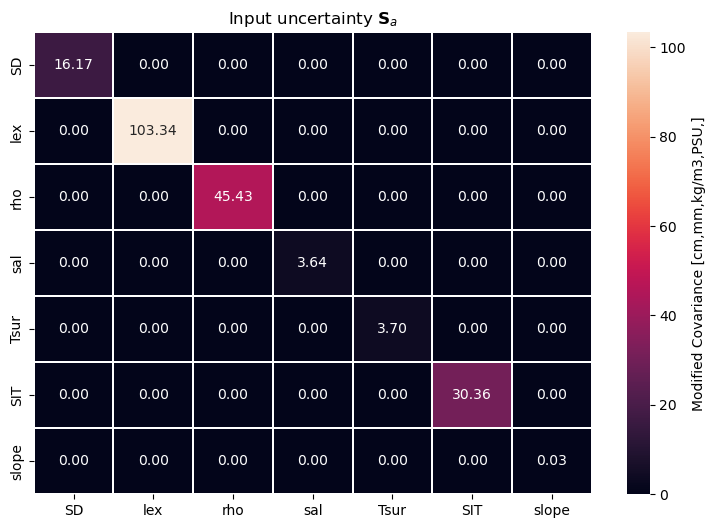

In [9]:
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)

print(x_vars)
print(x_ap)
print(x_cov)
print(y_vars)
print(y_obs)
print(y_cov)

# x_cov[2,2]=0.02**2

    

oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
title = r'Input uncertainty $\mathbf{S}_{a}$'
covMat(oe_show, oe_show.S_a, title)

Text(0.5, 1.0, 'Measurement uncertainty (STD) $\\mathbf{S}_{y}$')

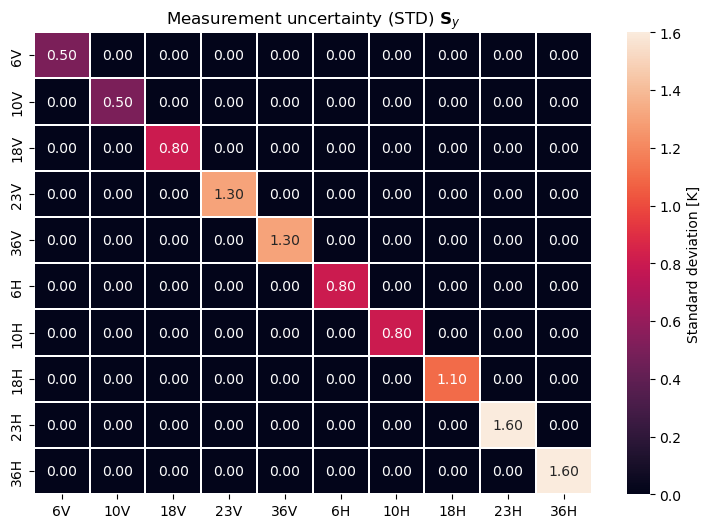

In [10]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    np.sqrt(oe_show.S_y), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Standard deviation [K]'}
)
ax.set_title(r'Measurement uncertainty (STD) $\mathbf{S}_{y}$')

[-8.23908741e-01 -3.61978876e+00  2.70000000e+02  1.30000000e-02
  2.53083775e+02  1.43982817e+00  1.90000000e-01]
8.56 s, iteration 1, degrees of freedom: 3.19 of 7, converged (x-space):  0.165
12.50 s, iteration 2, degrees of freedom: 3.22 of 7, done.  0.006
-----------------
TRUE VALUES
-----------------
SD:  0.1269940701468075
lex:  -3670.6021206389582
rho:  [335. 270.]
sal:  [0.01 4.  ]
SIT:  1.4398281690140846
-----------------
SD        -0.858747
lex       -3.636065
rho      268.258471
sal        0.012865
Tsur     252.641131
SIT        1.457509
slope      0.191507
dtype: float64
SD     13.843737
lex     0.023117
dtype: float64
-----------------
Jacobian matrix:
      perturbed SD  perturbed lex  perturbed rho  perturbed sal  \
6V       9.391605      -0.069155       0.013314      44.833087   
10V      9.716752      -0.383501       0.015169      66.581248   
18V      9.474352      -3.194304       0.016553     102.091545   
23V      7.984507      -7.360900       0.015131     111.67

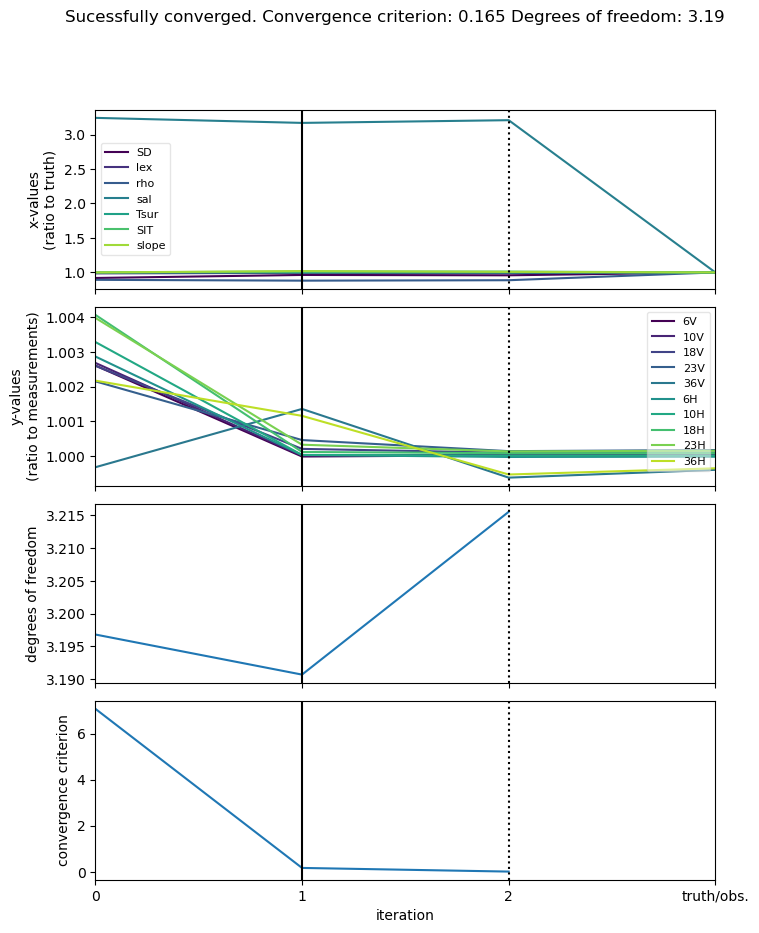

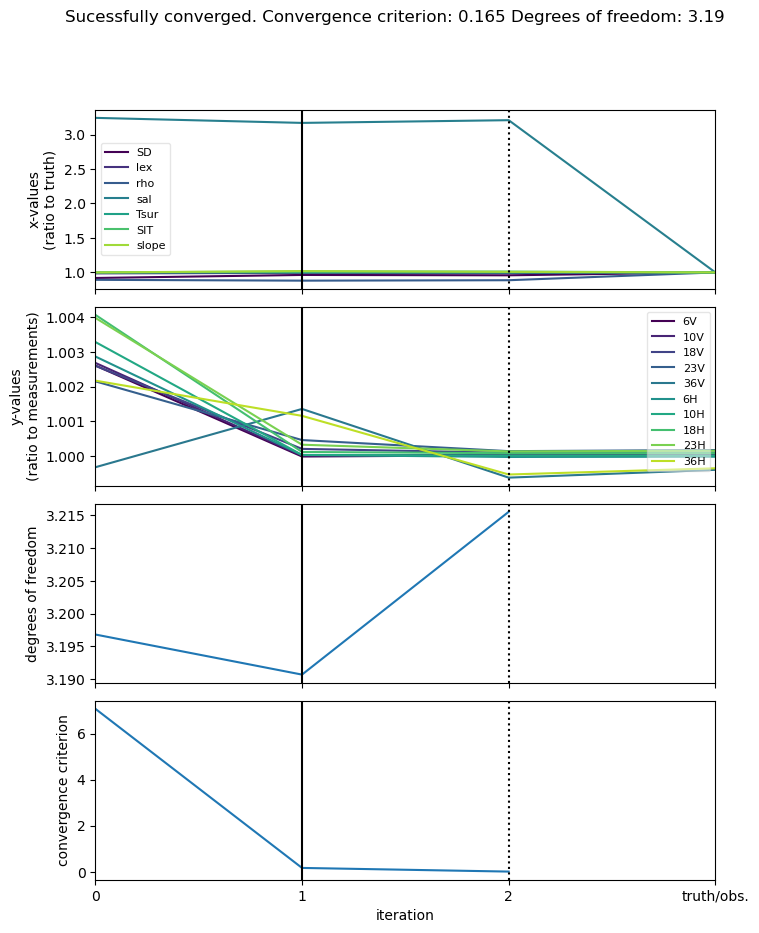

In [14]:
## Iterate over different start guesses
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
x_ap[0] = np.log10(0.15)
print(x_ap)
# x_cov[2,2]=0.02**2
forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                 "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,x_truth=x_truth
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=15)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', 10**np.mean(FYI_data.sd, axis=0))
print('lex: ',np.mean(FYI_data.sd_lex)*1e3)
print('rho: ',np.mean(FYI_data.sd_rho, axis=0))
print('sal: ',np.mean(FYI_data.sd_sal, axis=0)*1e3)
print('SIT: ',np.mean(FYI_data.sit))

print('-----------------')
print(oe.x_op)
print(10**(oe.x_op[:2])*1e2)
#try:
#    print(10**(oe.x_op[1:2])*1e3)
#except:
#    pass
#print((oe.x_op[2]))
print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

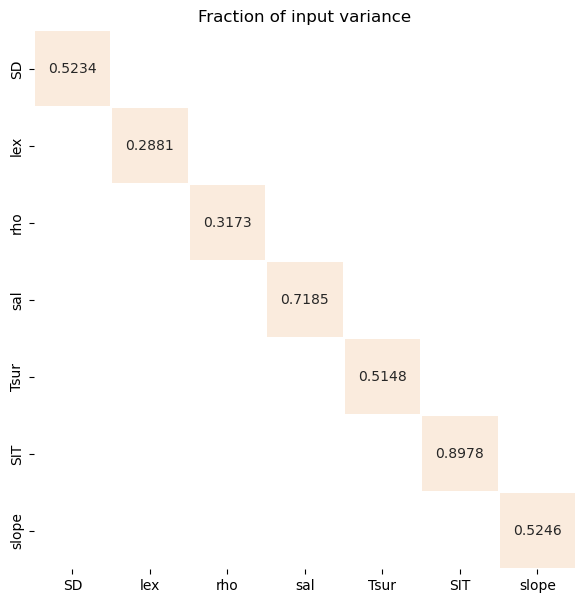

In [15]:
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe.S_op, oe_show.S_a)

last iteration not converged


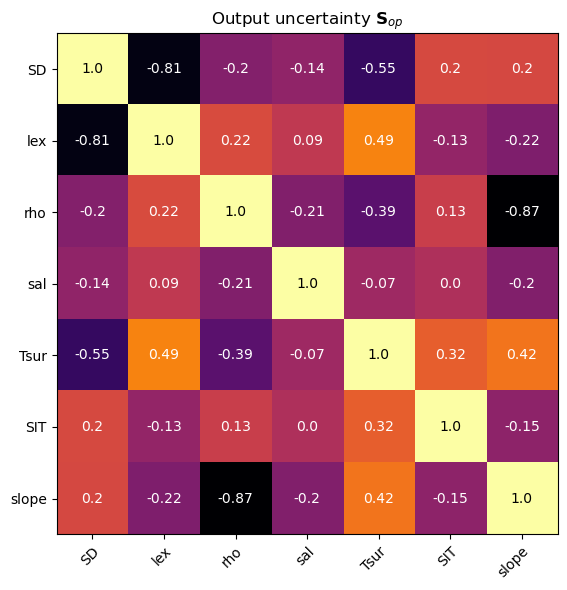

In [16]:
try:
    #def corrMat(data):
    corrMat = np.zeros(oe.S_op.shape)
    sigmas = np.diag(oe.S_op)**(1/2)
    rows = range(oe.S_op.shape[0])
    cols = range(oe.S_op.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)




    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
    ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(oe.S_op.keys())):
        for j in range(len(oe.S_op.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(slope_std) + '_CorrMatrixOut.png' )
    plt.show()
except:
    print('last iteration not converged')

In [57]:
## calculate angles if we have more than 1 input variable
input_variables=x_vars
text_file = open(savepath + "angles_jacobian.txt", "w")
if len(input_variables)>1:
    for i in range(len(input_variables)):
        for j in range(len(input_variables)):
            if i!=j:
                calc_ang(input_variables[i], input_variables[j])

--------------------------------------------------
Angle between SD and lex vector V: 93.17827836289167
Angle between SD and lex vector H: 114.10812278422411
--------------------------------------------------
Angle between SD and rho vector V: 23.659889357302255
Angle between SD and rho vector H: 10.156247357183386
--------------------------------------------------
Angle between SD and sal vector V: 48.88600640747487
Angle between SD and sal vector H: 17.31898420538603
--------------------------------------------------
Angle between SD and slope vector V: 156.20943386494383
Angle between SD and slope vector H: 13.158124272542157
--------------------------------------------------
Angle between lex and SD vector V: 93.17827836289167
Angle between lex and SD vector H: 114.10812278422411
--------------------------------------------------
Angle between lex and rho vector V: 116.44951474275757
Angle between lex and rho vector H: 120.25558717642612
--------------------------------------------

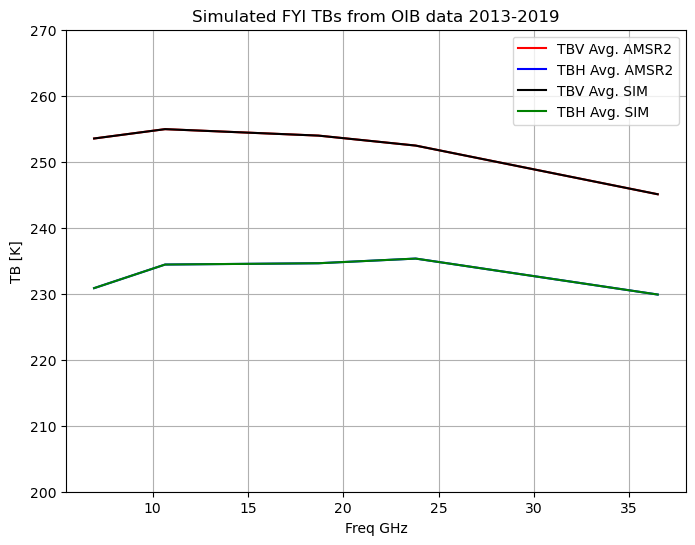

In [97]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

y = FYI_OIB_AMSR[:5]
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = FYI_OIB_AMSR[5:]
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = oe.y_op[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
if polarization =='both':
    y = oe.y_op[5:]
    plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

### Test for assumptions

In [59]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)
chiSquareTest = oe.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

Linearity test passed:  True
Warning. Singular Matrix with rank 5 instead of 10. (This is typically save to ignore)       
Warning. Singular Matrix with rank 4 instead of 5. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


SD
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.49 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.374
3.56 s, iteration 2, degrees of freedom: 3.03 of 7, done.  2.561
2.46 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.208
3.63 s, iteration 2, degrees of freedom: 3.11 of 7, done.  2.824
2.50 s, iteration 1, degrees of freedom: 3.44 of 7, not converged (x-space):  1.689
3.63 s, iteration 2, degrees of freedom: 3.43 of 7, converged (x-space):  0.053
4.77 s, iteration 3, degrees of freedom: 3.43 of 7, done.  0.042
2.57 s, iteration 1, degrees of freedom: 3.11 of 7, converged (x-space):  0.000
3.84 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.66 s, iteration 1, degrees of freedom: 3.20 of 7, converged (x-space):  0.083
3.96 s, iteration 2, degrees of freedom: 3.12 of 7, done.  0.019
2.64 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.192
3.85 s, iteration 2, degrees of freedom: 3.10 of 7, done

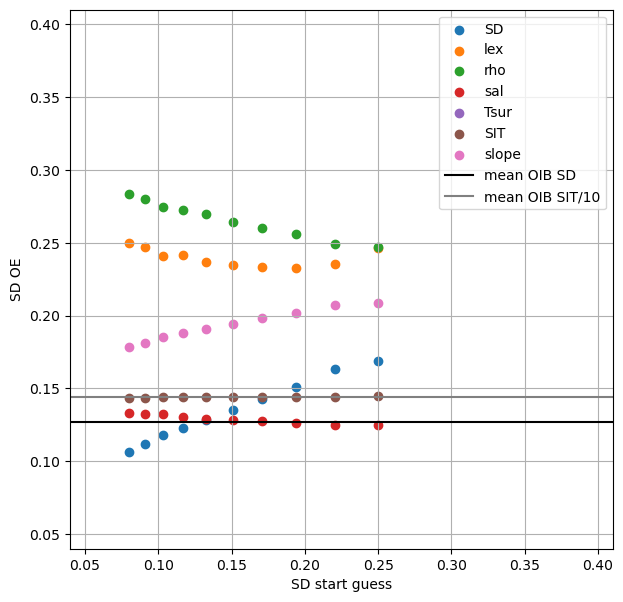

lex
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.48 s, iteration 1, degrees of freedom: 3.19 of 7, converged (x-space):  0.112
3.62 s, iteration 2, degrees of freedom: 3.16 of 7, done.  0.016
2.47 s, iteration 1, degrees of freedom: 3.19 of 7, converged (x-space):  0.019
3.63 s, iteration 2, degrees of freedom: 3.18 of 7, done.  0.012
2.52 s, iteration 1, degrees of freedom: 3.12 of 7, converged (x-space):  0.000
3.77 s, iteration 2, degrees of freedom: 3.12 of 7, done.  0.000
2.56 s, iteration 1, degrees of freedom: 3.11 of 7, converged (x-space):  0.001
3.72 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.68 s, iteration 1, degrees of freedom: 3.11 of 7, converged (x-space):  0.040
3.85 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.49 s, iteration 1, degrees of freedom: 3.12 of 7, converged (x-space):  0.242
3.65 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.51 s, iteration 1, degrees of freedom: 3.12 of 7, not converged (x-space

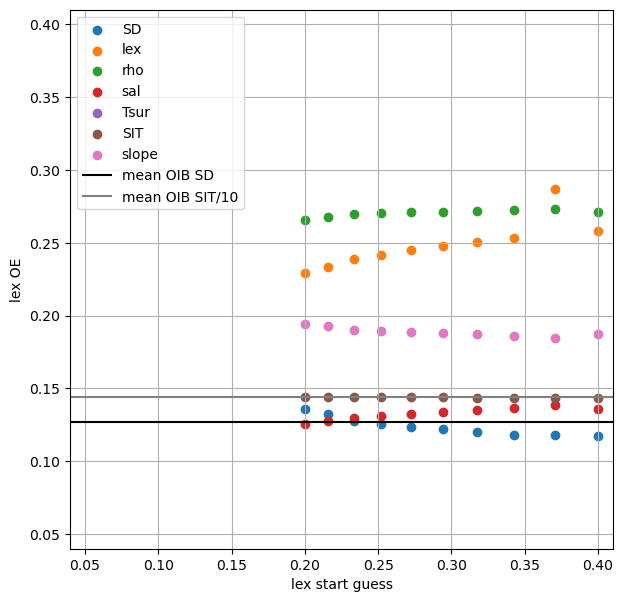

rho
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.51 s, iteration 1, degrees of freedom: 3.22 of 7, converged (x-space):  0.237
3.66 s, iteration 2, degrees of freedom: 3.13 of 7, done.  0.010
2.56 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.040
3.82 s, iteration 2, degrees of freedom: 3.09 of 7, done.  0.000
2.62 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.003
3.86 s, iteration 2, degrees of freedom: 3.10 of 7, done.  0.000
2.56 s, iteration 1, degrees of freedom: 3.12 of 7, converged (x-space):  0.004
3.78 s, iteration 2, degrees of freedom: 3.19 of 7, done.  0.000
2.62 s, iteration 1, degrees of freedom: 4.08 of 7, converged (x-space):  0.050
3.79 s, iteration 2, degrees of freedom: 3.89 of 7, done.  0.017
2.56 s, iteration 1, degrees of freedom: 3.24 of 7, converged (x-space):  0.469
3.73 s, iteration 2, degrees of freedom: 3.37 of 7, done.  3.045
2.52 s, iteration 1, degrees of freedom: 3.94 of 7, not converged (x-space

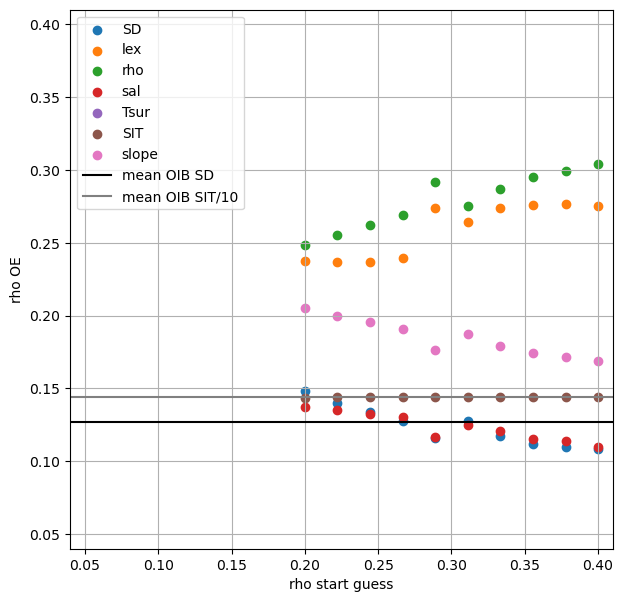

sal
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.59 s, iteration 1, degrees of freedom: 3.46 of 7, converged (x-space):  0.063
3.75 s, iteration 2, degrees of freedom: 3.47 of 7, done.  0.001
2.70 s, iteration 1, degrees of freedom: 3.47 of 7, converged (x-space):  0.036
3.88 s, iteration 2, degrees of freedom: 3.46 of 7, done.  0.001
2.58 s, iteration 1, degrees of freedom: 3.41 of 7, converged (x-space):  0.021
3.85 s, iteration 2, degrees of freedom: 3.41 of 7, done.  0.009
2.76 s, iteration 1, degrees of freedom: 3.14 of 7, converged (x-space):  0.001
3.95 s, iteration 2, degrees of freedom: 3.14 of 7, done.  0.000
2.56 s, iteration 1, degrees of freedom: 3.12 of 7, converged (x-space):  0.002
3.70 s, iteration 2, degrees of freedom: 3.12 of 7, done.  0.000
2.58 s, iteration 1, degrees of freedom: 3.11 of 7, converged (x-space):  0.000
3.78 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.59 s, iteration 1, degrees of freedom: 3.18 of 7, converged (x-space):  

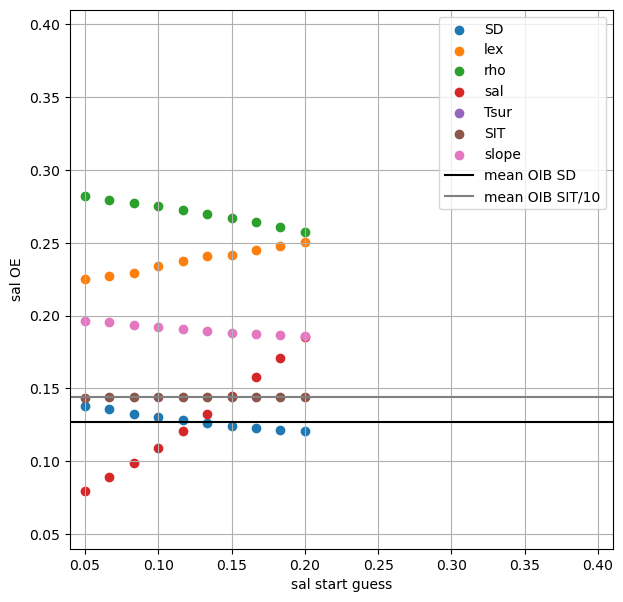

Tsur
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.50 s, iteration 1, degrees of freedom: 3.11 of 7, not converged (x-space):  0.996
3.71 s, iteration 2, degrees of freedom: 3.13 of 7, not converged (x-space):  2.513
4.88 s, iteration 3, degrees of freedom: 3.56 of 7, not converged (x-space):  4.322
6.08 s, iteration 4, degrees of freedom: 3.44 of 7, converged (x-space):  0.301
7.25 s, iteration 5, degrees of freedom: 3.51 of 7, done.  1.759
2.52 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.000
3.70 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.49 s, iteration 1, degrees of freedom: 3.09 of 7, converged (x-space):  0.255
3.65 s, iteration 2, degrees of freedom: 3.10 of 7, done.  0.000
2.41 s, iteration 1, degrees of freedom: 3.11 of 7, converged (x-space):  0.049
3.59 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.46 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.283
3.60 s, iteration 2, degrees of

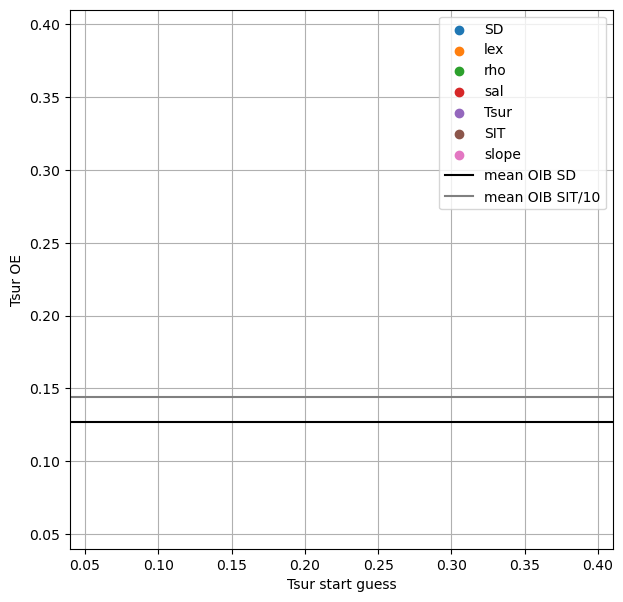

SIT
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.71 s, iteration 1, degrees of freedom: 3.18 of 7, converged (x-space):  0.692
4.11 s, iteration 2, degrees of freedom: 3.20 of 7, done.  0.004
2.56 s, iteration 1, degrees of freedom: 3.10 of 7, converged (x-space):  0.229
3.71 s, iteration 2, degrees of freedom: 3.11 of 7, done.  0.000
2.67 s, iteration 1, degrees of freedom: 3.26 of 7, converged (x-space):  0.321
3.84 s, iteration 2, degrees of freedom: 3.43 of 7, done.  0.733
2.49 s, iteration 1, degrees of freedom: 3.22 of 7, not converged (x-space):  1.689
3.70 s, iteration 2, degrees of freedom: 3.10 of 7, converged (x-space):  0.012
4.92 s, iteration 3, degrees of freedom: 3.11 of 7, done.  0.000
2.56 s, iteration 1, degrees of freedom: 3.08 of 7, not converged (x-space):  1.156
3.78 s, iteration 2, degrees of freedom: 3.10 of 7, converged (x-space):  0.000
4.97 s, iteration 3, degrees of freedom: 3.10 of 7, done.  0.000
2.45 s, iteration 1, degrees of freedom: 3.19 of 7,

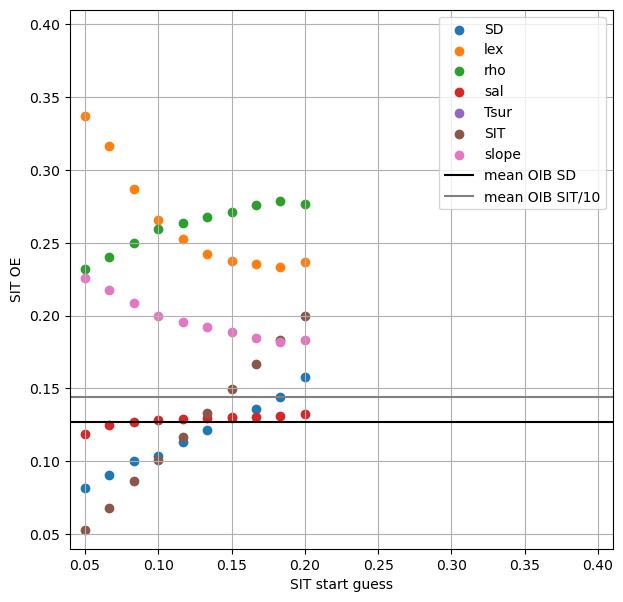

slope
['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
2.52 s, iteration 1, degrees of freedom: 2.99 of 7, not converged (x-space):  6.234
3.73 s, iteration 2, degrees of freedom: 3.12 of 7, converged (x-space):  0.192
4.94 s, iteration 3, degrees of freedom: 3.13 of 7, done.  0.009
2.54 s, iteration 1, degrees of freedom: 3.05 of 7, not converged (x-space):  4.365
3.77 s, iteration 2, degrees of freedom: 3.19 of 7, converged (x-space):  0.062
4.96 s, iteration 3, degrees of freedom: 3.31 of 7, done.  0.002
2.55 s, iteration 1, degrees of freedom: 3.08 of 7, not converged (x-space):  3.662
3.80 s, iteration 2, degrees of freedom: 3.18 of 7, converged (x-space):  0.039
5.03 s, iteration 3, degrees of freedom: 3.19 of 7, done.  0.000
2.65 s, iteration 1, degrees of freedom: 3.45 of 7, not converged (x-space):  3.144
3.86 s, iteration 2, degrees of freedom: 3.79 of 7, converged (x-space):  0.033
5.11 s, iteration 3, degrees of freedom: 3.67 of 7, done.  0.003
2.62 s, iteration 1, degre

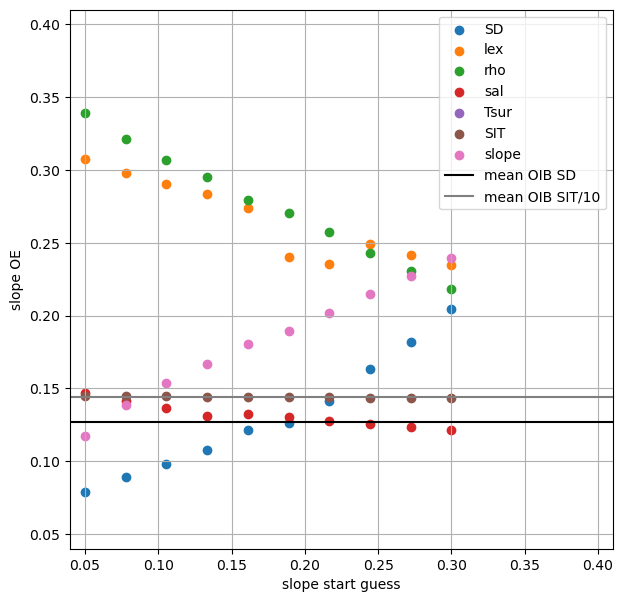

In [98]:
## Iterate over different start guesses (of SD)
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/Real_data/Report_figures/'
slope_std ='_SIT_TSUR'
input_variables = x_vars
for var in input_variables:
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
    x_cov[-3,-3] = 1**2 # 1K
    x_cov[-2,-2] = (0.05)**2 # 5 cm
    print(var)
    print(input_variables)
    #x_cov[0,0] = x_cov[0,0]*2
    # x_cov[-1,-1] = x_cov[-1,-1]*2
    cc = []
    x_op = []
    ind = [i==var for i in input_variables]
    if var=='SD':
        if logarithmic==True:
            V0 = np.linspace(np.log10(0.08), np.log10(0.25), 10)
        else:
            V0 = np.linspace(0.08, 0.25, 10)
    elif var=='lex':
        if logarithmic==True:
            V0 =  np.linspace(np.log10(0.2*1e-3), np.log10(0.4*1e-3), 10)
        else:
            V0 =  np.linspace(0.2*1e-3, 0.4*1e-3, 10)
    elif var=='sal':
        V0 =  np.linspace(5*PSU, 20*PSU, 10)
        # V0 =  np.linspace(np.log10(0.1*PSU), np.log10(2*PSU), 10)
    elif var=='rho':
        V0 = np.linspace(200, 400, 10)
    elif var=='Tsur':
        V0 = np.linspace(250, 270, 10)
    elif var=='SIT':
        V0 = np.linspace(0.5, 2.0, 10)
    elif var=='slope':
        V0 = np.linspace(0.05, 0.3, 10)

    for v0 in V0:
        x_ap[ind] =v0
        ## define extra arguments to forward function
        forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                         "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,x_truth=x_truth
                ,convergenceFactor=10
                )

        try:
            # run the optimization and print outputs
            oe.doRetrieval(maxIter=6)
            oe.plotIterations
            cc.append(oe.S_op)
            x_op.append(oe.x_op)
        except:
            print('NC')
            V0 = np.delete(V0, [np.where(V0==v0)])
        
    ## Plot results
    plt.figure(figsize=(7,7))
    # print(var)
    for i in range(len(input_variables)):
        print(i)
        
        if input_variables[i]!="SIT" and input_variables[i]!="rho" and input_variables[i]!="sal" and input_variables[i]!="slope" and logarithmic==True:
            V = [10**x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        else:
            V = [x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        if var!="SIT" and var!="rho" and var!="sal" and var!='slope' and logarithmic==True:
            VV0 = [10**v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        else:
            VV0 = [v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        if input_variables[i]=="lex" or input_variables[i]=="sal":
            V = np.array(V)*1e3
        if var=="lex" or var=="sal":
            VV0 = np.array(VV0)*1e3
        if var=="sal":
            VV0 = VV0/100
        if input_variables[i]=="sal":
            V=V/100
        if var=='rho' or var=='Tsur':
            VV0 = np.array(VV0)/1000
        if input_variables[i]=="rho":
            V = np.array(V)/1000
        if input_variables[i]=="Tsur":
            V = np.array(V)/1000
        if var=="SIT":
            VV0 = np.array(VV0)/10
        if input_variables[i]=="SIT":
            V=np.array(V)/10
        # print(VV0)
        # print(V)
        plt.scatter(VV0, V, label=input_variables[i])
    # print(np.mean(10**FYI_data.sd))
    plt.xlabel(var + ' start guess')
    plt.ylabel(var +' OE')
    if logarithmic==True:
        plt.axhline(10**np.mean(FYI_data.sd, axis=0), color='k', label='mean OIB SD')
    else:
        plt.axhline(np.mean(FYI_data.sd), color='k', label='mean OIB SD')
    plt.axhline(np.mean(FYI_data.sit)/10, color='grey', label='mean OIB SIT/10')
    # plt.axhline(np.mean(FYI_data.sd_lex, axis=0)[0]*1e3, color='b', label='mean OIB lex')
    # plt.axhline(np.mean(FYI_data.sd_sal, axis=0)[0]*1e3/3, color='r', label='mean OIB sal/3')
    plt.xlim([0.04, 0.41])
    plt.ylim([0.04, 0.41])
    #plt.xlim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    #plt.ylim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    plt.legend()
    plt.grid()
    plt.savefig(savepath + var + '_' + str(slope_std) + '.png' )
    plt.show()

In [15]:
ns = len(FYI_data.skt)
slope_std ='_sy_smaller'
nl_snow = 3
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
x_cov[-3,-3] = 1**2 # 1K
x_cov[-2,-2] = (0.05)**2 # 5 cm
#x_cov[3,3] = (4*PSU)**2
#x_cov[4,4] = 0.05**2
#print(polarization)

def do_OE_sim(ns, noise=False):
    if polarization=='both':
        data=zip(FYI_data.TbV_AMSR_all[:ns], FYI_data.TbH_AMSR_all[:ns])
        # data=zip(FYI_data.TbV_sim[:ns], FYI_data.TbH_sim[:ns])
    elif polarization=='V':
        data=FYI_data.TbV_AMSR_all[:ns]
    elif polarization=='VH0':
        data=zip(FYI_data.TbV_AMSR_all[:ns], FYI_data.TbH_AMSR_all[:ns][:,0])
    oe_out = []
    results = []
    x_optimals = []
    nn = [] # [i for i in range(ns)]
    no = []
    for Tb, n in zip(data, range(len(FYI_data.skt[:ns]))):
        [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, n=n, logarithmic=True, nl_snow=nl_snow)
        x_cov[-3,-3] = 1**2 # 1K
        x_cov[-2,-2] = (0.10)**2 # 5 cm
        print('Point number: ', n)
        # y_obs = np.append(Tb[0],Tb[1])
        #print(y_obs)
        y_obs = np.concatenate(Tb)
        # y_obs = Tb
        ## define extra arguments to forward function
        forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": n, 
                         "pol":polarization, "logarithmic":True,"avg":False, "sim":False}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,x_truth=x_truth
                ,convergenceFactor=10
                )
        try:
            oe.doRetrieval(maxIter=4)
            linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(significance=0.05)
            #if trueLinearityChi2 < trueLinearityChi2Crit:
            #    T_percentage
            # print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)
            # chiSquareTest = oe.chiSquareTest(significance=0.05)
            #print('\nTests passed:\n' ,chiSquareTest[0])
            #print(len(np.where(chiSquareTest[0]==True)[0]))
            #if all(chiSquareTest[0]):
            nn.append(n)
            x_optimals.append(oe.x_op)
            results.append(oe.y_op)
            oe_out.append(oe)
            
        except:
            print('Convergence not reached')
            # nn.remove(n)
            no.append(n)
    return [nn, no, oe_out, x_optimals, results]

[nn, no, oe_out, x_optimals, results] = do_OE_sim(ns)

know value guesses
Point number:  0
1.87 s, iteration 1, degrees of freedom: 4.37 of 7, not converged (x-space):  72.995
2.83 s, iteration 2, degrees of freedom: 3.93 of 7, not converged (x-space):  5.720
3.75 s, iteration 3, degrees of freedom: 3.99 of 7, not converged (x-space):  5.263
did not converge
Convergence not reached
know value guesses
Point number:  1
1.99 s, iteration 1, degrees of freedom: 3.77 of 7, not converged (x-space):  4.762
2.87 s, iteration 2, degrees of freedom: 3.33 of 7, not converged (x-space):  1.505
3.81 s, iteration 3, degrees of freedom: 3.92 of 7, not converged (x-space):  5.197
did not converge
Convergence not reached
know value guesses
Point number:  2
1.96 s, iteration 1, degrees of freedom: 3.16 of 7, not converged (x-space):  2.229
2.89 s, iteration 2, degrees of freedom: 3.93 of 7, converged (x-space):  0.506
3.90 s, iteration 3, degrees of freedom: 3.56 of 7, done.  0.012
know value guesses
Point number:  3
1.97 s, iteration 1, degrees of freedom:

3.00 s, iteration 2, degrees of freedom: 3.11 of 7, not converged (x-space):  1.235
3.94 s, iteration 3, degrees of freedom: 3.10 of 7, converged (x-space):  0.004
know value guesses
Point number:  31
2.09 s, iteration 1, degrees of freedom: 3.83 of 7, not converged (x-space):  39.698
3.07 s, iteration 2, degrees of freedom: 3.30 of 7, converged (x-space):  0.221
4.05 s, iteration 3, degrees of freedom: 3.28 of 7, done.  0.012
know value guesses
Point number:  32
2.02 s, iteration 1, degrees of freedom: 3.99 of 7, not converged (x-space):  5.132
3.00 s, iteration 2, degrees of freedom: 3.63 of 7, converged (x-space):  0.276
3.98 s, iteration 3, degrees of freedom: 3.99 of 7, done.  1.864
know value guesses
Point number:  33
2.03 s, iteration 1, degrees of freedom: 3.48 of 7, not converged (x-space):  0.916
3.00 s, iteration 2, degrees of freedom: 3.69 of 7, not converged (x-space):  5.528
3.97 s, iteration 3, degrees of freedom: 2.99 of 7, converged (x-space):  0.692
know value guesses

3.98 s, iteration 3, degrees of freedom: 3.97 of 7, done.  1.557
know value guesses
Point number:  62
2.01 s, iteration 1, degrees of freedom: 4.19 of 7, not converged (x-space):  7.963
2.94 s, iteration 2, degrees of freedom: 3.68 of 7, not converged (x-space):  9.494
3.90 s, iteration 3, degrees of freedom: 3.28 of 7, converged (x-space):  0.629
know value guesses
Point number:  63
2.16 s, iteration 1, degrees of freedom: 3.01 of 7, not converged (x-space):  0.824
3.19 s, iteration 2, degrees of freedom: 3.02 of 7, converged (x-space):  0.007
4.20 s, iteration 3, degrees of freedom: 3.02 of 7, done.  0.000
know value guesses
Point number:  64
2.38 s, iteration 1, degrees of freedom: 3.04 of 7, not converged (x-space):  2.505
3.53 s, iteration 2, degrees of freedom: 3.05 of 7, converged (x-space):  0.031
4.72 s, iteration 3, degrees of freedom: 3.05 of 7, done.  0.000
know value guesses
Point number:  65
2.37 s, iteration 1, degrees of freedom: 3.32 of 7, converged (x-space):  0.215
3

3.89 s, iteration 3, degrees of freedom: 2.99 of 7, done.  0.000
know value guesses
Point number:  94
1.99 s, iteration 1, degrees of freedom: 2.64 of 7, not converged (x-space):  13.570
2.97 s, iteration 2, degrees of freedom: 2.83 of 7, not converged (x-space):  1.979
3.91 s, iteration 3, degrees of freedom: 2.87 of 7, converged (x-space):  0.263
know value guesses
Point number:  95
1.99 s, iteration 1, degrees of freedom: 2.84 of 7, not converged (x-space):  3.701
2.97 s, iteration 2, degrees of freedom: 3.03 of 7, converged (x-space):  0.698
3.91 s, iteration 3, degrees of freedom: 3.05 of 7, done.  0.010
know value guesses
Point number:  96
1.97 s, iteration 1, degrees of freedom: 2.96 of 7, not converged (x-space):  2.166
2.91 s, iteration 2, degrees of freedom: 2.93 of 7, converged (x-space):  0.030
3.84 s, iteration 3, degrees of freedom: 2.92 of 7, done.  0.001
know value guesses
Point number:  97
2.05 s, iteration 1, degrees of freedom: 3.41 of 7, not converged (x-space):  17

3.20 s, iteration 2, degrees of freedom: 3.25 of 7, converged (x-space):  0.055
4.24 s, iteration 3, degrees of freedom: 3.39 of 7, done.  0.052
know value guesses
Point number:  125
2.25 s, iteration 1, degrees of freedom: 3.23 of 7, not converged (x-space):  3.562
3.30 s, iteration 2, degrees of freedom: 3.23 of 7, converged (x-space):  0.009
4.36 s, iteration 3, degrees of freedom: 3.23 of 7, done.  0.000
know value guesses
Point number:  126
4.56 s, iteration 1, degrees of freedom: 3.15 of 7, not converged (x-space):  9.460
6.79 s, iteration 2, degrees of freedom: 3.14 of 7, converged (x-space):  0.176
8.99 s, iteration 3, degrees of freedom: 3.14 of 7, done.  0.001
know value guesses
Point number:  127
2.08 s, iteration 1, degrees of freedom: 2.98 of 7, not converged (x-space):  1.214
3.04 s, iteration 2, degrees of freedom: 2.90 of 7, converged (x-space):  0.005
4.02 s, iteration 3, degrees of freedom: 2.90 of 7, done.  0.000
know value guesses
Point number:  128
2.10 s, iteratio

Point number:  156
2.08 s, iteration 1, degrees of freedom: 3.40 of 7, not converged (x-space):  0.786
3.07 s, iteration 2, degrees of freedom: 3.30 of 7, converged (x-space):  0.022
4.07 s, iteration 3, degrees of freedom: 3.32 of 7, done.  0.051
know value guesses
Point number:  157
2.08 s, iteration 1, degrees of freedom: 3.64 of 7, not converged (x-space):  6.854
3.05 s, iteration 2, degrees of freedom: 3.27 of 7, converged (x-space):  0.674
4.03 s, iteration 3, degrees of freedom: 3.15 of 7, done.  3.412
know value guesses
Point number:  158
4.49 s, iteration 1, degrees of freedom: 3.92 of 7, not converged (x-space):  53.752
6.69 s, iteration 2, degrees of freedom: 3.79 of 7, not converged (x-space):  2.029
8.91 s, iteration 3, degrees of freedom: 3.68 of 7, converged (x-space):  0.024
know value guesses
Point number:  159
2.08 s, iteration 1, degrees of freedom: 4.60 of 7, not converged (x-space):  22.523
3.04 s, iteration 2, degrees of freedom: 3.92 of 7, not converged (x-space)

3.07 s, iteration 2, degrees of freedom: 3.52 of 7, not converged (x-space):  0.739
4.04 s, iteration 3, degrees of freedom: 3.09 of 7, converged (x-space):  0.331
know value guesses
Point number:  187
2.07 s, iteration 1, degrees of freedom: 3.39 of 7, not converged (x-space):  10.317
3.02 s, iteration 2, degrees of freedom: 3.87 of 7, not converged (x-space):  1.479
4.00 s, iteration 3, degrees of freedom: 3.30 of 7, converged (x-space):  0.141
know value guesses
Point number:  188
2.08 s, iteration 1, degrees of freedom: 3.24 of 7, not converged (x-space):  1.784
3.05 s, iteration 2, degrees of freedom: 3.66 of 7, not converged (x-space):  1.136
4.05 s, iteration 3, degrees of freedom: 3.27 of 7, converged (x-space):  0.149
know value guesses
Point number:  189
2.02 s, iteration 1, degrees of freedom: 3.07 of 7, not converged (x-space):  0.766
2.99 s, iteration 2, degrees of freedom: 2.92 of 7, converged (x-space):  0.205
3.95 s, iteration 3, degrees of freedom: 2.96 of 7, done.  0.

2.97 s, iteration 2, degrees of freedom: 3.78 of 7, converged (x-space):  0.230
3.93 s, iteration 3, degrees of freedom: 3.54 of 7, done.  0.618
know value guesses
Point number:  221
2.13 s, iteration 1, degrees of freedom: 3.29 of 7, not converged (x-space):  2.115
3.11 s, iteration 2, degrees of freedom: 3.77 of 7, converged (x-space):  0.182
4.07 s, iteration 3, degrees of freedom: 3.43 of 7, done.  0.339
know value guesses
Point number:  222
2.07 s, iteration 1, degrees of freedom: 3.79 of 7, not converged (x-space):  0.998
3.04 s, iteration 2, degrees of freedom: 3.33 of 7, converged (x-space):  0.208
4.01 s, iteration 3, degrees of freedom: 3.50 of 7, done.  0.037
know value guesses
Point number:  223
2.04 s, iteration 1, degrees of freedom: 3.26 of 7, converged (x-space):  0.046
3.06 s, iteration 2, degrees of freedom: 3.24 of 7, done.  0.000
know value guesses
Point number:  224
2.06 s, iteration 1, degrees of freedom: 3.18 of 7, converged (x-space):  0.208
3.03 s, iteration 2,

4.09 s, iteration 3, degrees of freedom: 3.50 of 7, converged (x-space):  0.023
know value guesses
Point number:  255
2.12 s, iteration 1, degrees of freedom: 3.37 of 7, converged (x-space):  0.338
3.12 s, iteration 2, degrees of freedom: 3.45 of 7, done.  0.551
know value guesses
Point number:  256
2.15 s, iteration 1, degrees of freedom: 3.82 of 7, not converged (x-space):  9.316
3.17 s, iteration 2, degrees of freedom: 3.10 of 7, converged (x-space):  0.626
4.21 s, iteration 3, degrees of freedom: 2.89 of 7, done.  0.079
know value guesses
Point number:  257
2.08 s, iteration 1, degrees of freedom: 3.29 of 7, not converged (x-space):  9.552
3.10 s, iteration 2, degrees of freedom: 3.03 of 7, not converged (x-space):  1.561
4.08 s, iteration 3, degrees of freedom: 3.50 of 7, converged (x-space):  0.264
know value guesses
Point number:  258
2.15 s, iteration 1, degrees of freedom: 2.92 of 7, converged (x-space):  0.422
3.12 s, iteration 2, degrees of freedom: 3.77 of 7, done.  0.327
k

know value guesses
Point number:  287
2.13 s, iteration 1, degrees of freedom: 3.77 of 7, not converged (x-space):  49.318
3.20 s, iteration 2, degrees of freedom: 4.32 of 7, not converged (x-space):  4.051
4.18 s, iteration 3, degrees of freedom: 4.32 of 7, not converged (x-space):  3.201
did not converge
Convergence not reached
know value guesses
Point number:  288
2.03 s, iteration 1, degrees of freedom: 3.30 of 7, not converged (x-space):  23.257
3.02 s, iteration 2, degrees of freedom: 3.28 of 7, converged (x-space):  0.341
4.02 s, iteration 3, degrees of freedom: 3.71 of 7, done.  0.506
know value guesses
Point number:  289
2.00 s, iteration 1, degrees of freedom: 3.30 of 7, not converged (x-space):  10.740
2.99 s, iteration 2, degrees of freedom: 3.30 of 7, converged (x-space):  0.132
3.99 s, iteration 3, degrees of freedom: 3.29 of 7, done.  0.000
know value guesses
Point number:  290
2.18 s, iteration 1, degrees of freedom: 3.32 of 7, not converged (x-space):  3.980
3.17 s, it

Point number:  321
1.99 s, iteration 1, degrees of freedom: 3.20 of 7, converged (x-space):  0.369
2.98 s, iteration 2, degrees of freedom: 3.19 of 7, done.  0.000
know value guesses
Point number:  322
2.14 s, iteration 1, degrees of freedom: 3.18 of 7, converged (x-space):  0.615
3.05 s, iteration 2, degrees of freedom: 3.17 of 7, done.  0.000
know value guesses
Point number:  323
2.17 s, iteration 1, degrees of freedom: 3.47 of 7, not converged (x-space):  63.293
3.13 s, iteration 2, degrees of freedom: 3.39 of 7, not converged (x-space):  0.971
4.11 s, iteration 3, degrees of freedom: 3.37 of 7, converged (x-space):  0.012
know value guesses
Point number:  324
2.01 s, iteration 1, degrees of freedom: 3.45 of 7, not converged (x-space):  44.782
3.00 s, iteration 2, degrees of freedom: 3.37 of 7, converged (x-space):  0.588
3.95 s, iteration 3, degrees of freedom: 3.36 of 7, done.  0.005
know value guesses
Point number:  325
2.30 s, iteration 1, degrees of freedom: 3.50 of 7, not conv

3.98 s, iteration 3, degrees of freedom: 2.51 of 7, not converged (x-space):  2.479
did not converge
Convergence not reached
know value guesses
Point number:  353
2.01 s, iteration 1, degrees of freedom: 2.66 of 7, not converged (x-space):  7.328
2.94 s, iteration 2, degrees of freedom: 2.59 of 7, converged (x-space):  0.189
3.90 s, iteration 3, degrees of freedom: 2.66 of 7, done.  0.087
know value guesses
Point number:  354
2.04 s, iteration 1, degrees of freedom: 2.79 of 7, not converged (x-space):  3.272
3.02 s, iteration 2, degrees of freedom: 2.97 of 7, not converged (x-space):  1.295
3.96 s, iteration 3, degrees of freedom: 2.90 of 7, not converged (x-space):  2.438
did not converge
Convergence not reached


In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

def RMSE(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
    
    print("Root Mean Square Error:")
    print(RMSE)
    return RMSE

['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']
Root Mean Square Error:
0.044338949836101316
[ 24  28  39  66  68  83  84  85  86  88  94  95  96  98  99 101 119 120
 121 125 126 128 134 135 136 137 138 147 149 150 151 152 153 154 155 156
 157 165 166 208 211 213 221 224 225 233 234 236 240 242 243 244 245 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 274 275 276 277 278 283 284 285 286 287 288 289 290 291 292 295 296
 297 298 299 300 301]
Root Mean Square Error:
0.044338949836101316


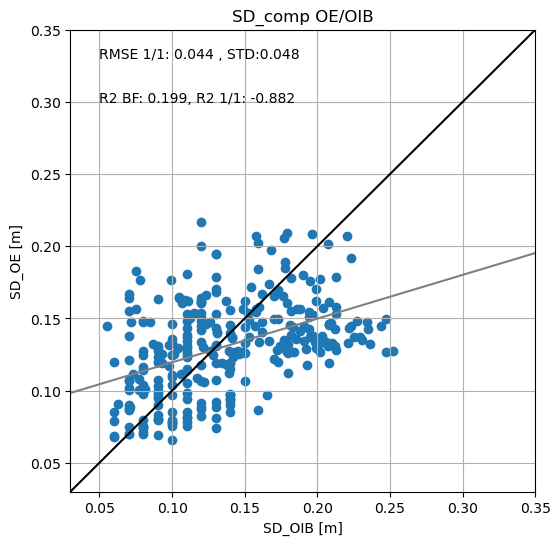

Root Mean Square Error:
0.0


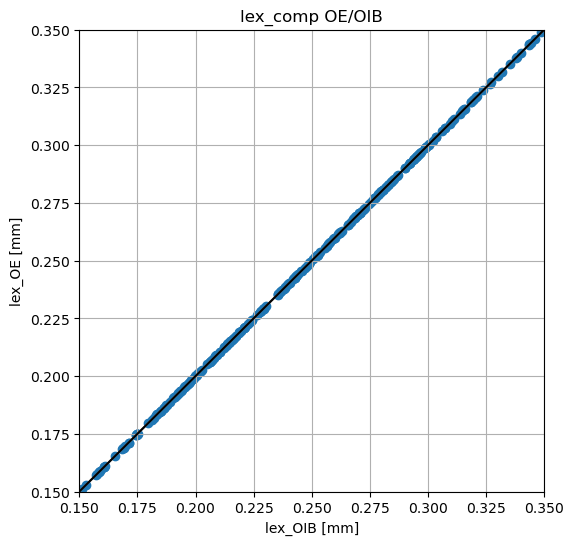

Root Mean Square Error:
0.0


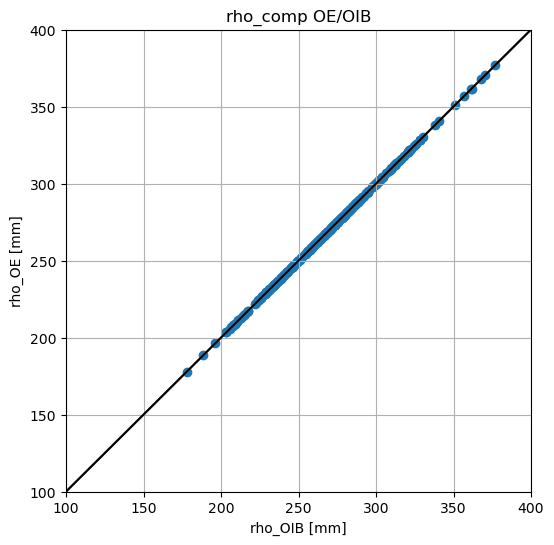

Root Mean Square Error:
0.0


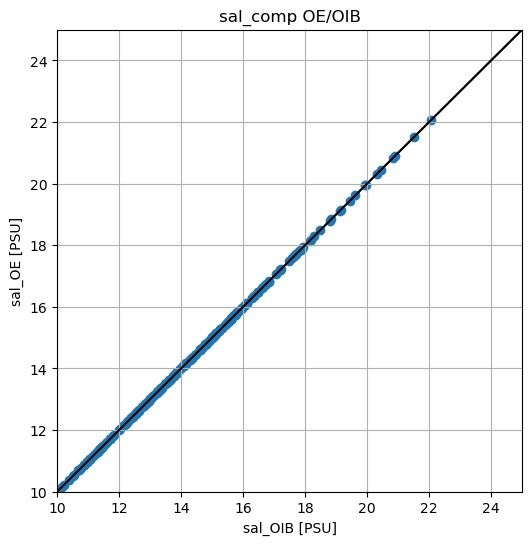

Root Mean Square Error:
0.32353100510579835


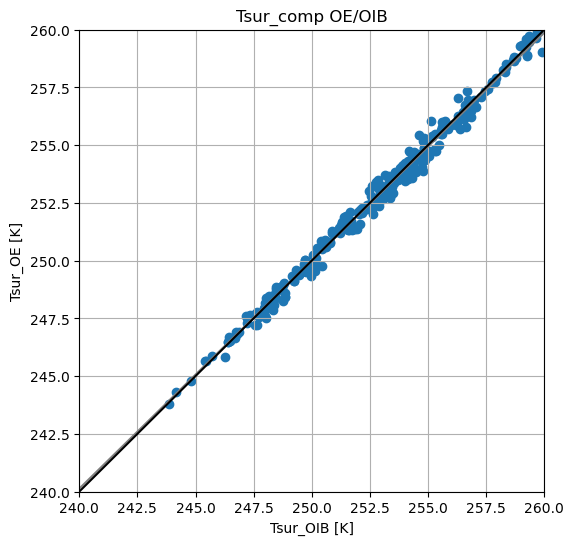

Root Mean Square Error:
0.021123558959809653
Root Mean Square Error:
0.021123558959809653


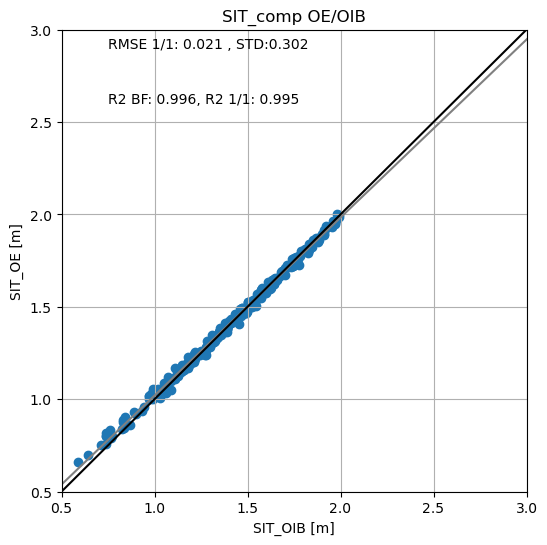

Root Mean Square Error:
0.0


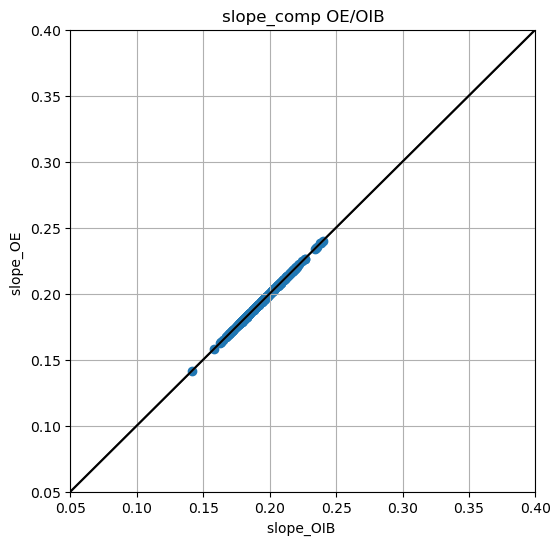

In [20]:
slope_std ='_sy_smaller'
# slope_std ='final'
no = []
input_variables=x_vars
def plot_idv(variables, OIB_data, nn):

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OIB = []
        #set limits
        for x_optim, n in zip(x_optimals, nn):
            try:
                if (var=='SD' or var=='lex') and logarithmic==True:
                    # convert from log to linear units
                    OE.append(10**x_optim[var])
                else:
                    OE.append(x_optim[var.replace('1', '')])
                OIB.append(data[n])
            except:
                # print('convergence was not reached at: ', n)
                no.append(n)
        
        if var=='SD' or var=='sal' or var=='lex':
            OIB = np.array(OIB)
            
        
        #print(np.shape(OIB))
        #print(np.shape(OE))
        if var=='SD':
            xlim = [0.03, 0.35]
            x = 0.05
            y = 0.33
            y1 = 0.30
            unit = ' [m]'
        elif var=='sal':
            xlim = [10, 25.0]
            unit = ' [PSU]'
            OIB = np.array(OE)*1e3
            # OIB = OIB*1e3
            x = 10.8
            y = 12.9
            OE = np.array(OE)*1e3
        elif var=='Tsur':
            xlim = [240.0, 260.0]
            unit = ' [K]'
            x = 10.8
            y = 12.9
        elif var=='lex':
            OIB = np.array(OE)*1e3
            OE = np.array(OE)*1e3
            xlim = [0.15, 0.35]
            unit = ' [mm]'
            x = 0.18
            y = 0.28
            #OIB = OIB*1e3
            #OE = np.array(OE)*1e3
        elif var=='SIT':
            xlim = [0.5, 3.0]
            x = 0.75
            y = 2.9
            y1 = 2.6
            unit = ' [m]'
        elif var=='slope':
            # print(OIB)
            # print('OE value')
            # print(OE)
            OIB = OE
            xlim = [0.05, 0.4]
            x = 0.1
            y = 0.3
            unit = ' '
        elif 'rho' in var:
            #print(var)
            #print(OIB)
            #OIB = np.array(OIB)[:,1]
            OIB = OE
            xlim = [100, 400]


        ## make predictions and fit
        model = np.polyfit(OIB, OE, 1)
        model2 = np.polyfit(OIB, OIB, 1)
        
        predict = np.poly1d(model)
        predict2 = np.poly1d(model2)

        rr=r2_score(OE, predict(OIB))
        rr2=r2_score(OE, predict2(OIB))
        
        x_lin_reg = range(-1, 500)
        y_lin_reg = predict(x_lin_reg)

        x_one2one = range(-1, 500)
        y_one2one = predict2(x_lin_reg)
        
        rmse = RMSE(OIB, OE)
        
        plt.figure(figsize=(6,6))
        if var=='SD':
            BD = np.where(abs(OIB-OE)>rmse)[0]
            print(BD)
        plt.scatter(OIB, OE)
        # plt.scatter(np.array(OIB)[BD.astype(int)], np.array(OE)[BD.astype(int)])
        plt.plot(x_lin_reg, y_lin_reg, c = 'gray')
        plt.plot(x_one2one, y_one2one, c = 'black')
        plt.grid()
        plt.title(var + '_comp OE/OIB')
        plt.xlabel(var + '_OIB' + unit)
        plt.ylabel(var + '_OE' + unit)
        plt.xlim(xlim)
        # square plot
        plt.ylim(xlim)
        

        
        # print('R2-score: ',r2_score(OIB,OE))
        # print(np.std(OIB))
        if var=='SD' or var=='SIT':
            plt.text(x, y, 'RMSE 1/1: ' + str(np.round(RMSE(OIB, OE),3)) + ' , STD:' + str(np.round(np.std(OIB),3)))
            plt.text(x, y1, 'R2 BF: ' + str(np.round(rr,3)) + ', R2 1/1: ' + str(np.round(rr2,3)))
        # plt.text(x, y-0.06, 'R2: ' + str(np.round(rr2,3)))
        plt.savefig(savepath + var + '_' + str(slope_std) +'_idv.png' )
        plt.show()
    return BD



# take nn of each
OIB_data_plot = []
print(input_variables)
if 'SD' in input_variables:
    if logarithmic==True:
        OIB_data_plot.append(10**FYI_data.sd)
    else:
        OIB_data_plot.append(FYI_data.sd)
if 'lex' in input_variables:
    if logarithmic==True:
        OIB_data_plot.append(10**FYI_data.sd_lex)
    else:
        OIB_data_plot.append(FYI_data.sd_lex)
if 'rho' in input_variables:
    OIB_data_plot.append(FYI_data.sd_rho)
    
if 'sal' in input_variables:
    #if logarithmic==True:
    #    OIB_data_plot.append(10**FYI_data.sd_sal)
    #else:
    OIB_data_plot.append(FYI_data.sd_sal)
if 'Tsur' in input_variables:
    #if logarithmic==True:
    #    OIB_data_plot.append(10**FYI_data.sd_sal)
    #else:
    OIB_data_plot.append(FYI_data.skt)
if 'SIT' in input_variables:
    OIB_data_plot.append(FYI_data.sit)
if 'slope' in input_variables:
    OIB_data_plot.append(FYI_data.OIB_surf_rough)
BD = plot_idv(input_variables, OIB_data_plot, nn)

['SD', 'lex', 'rho', 'sal', 'Tsur', 'SIT', 'slope']


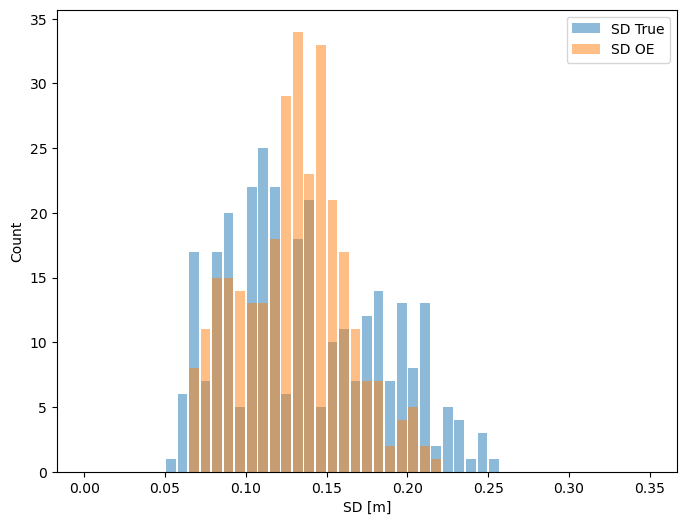

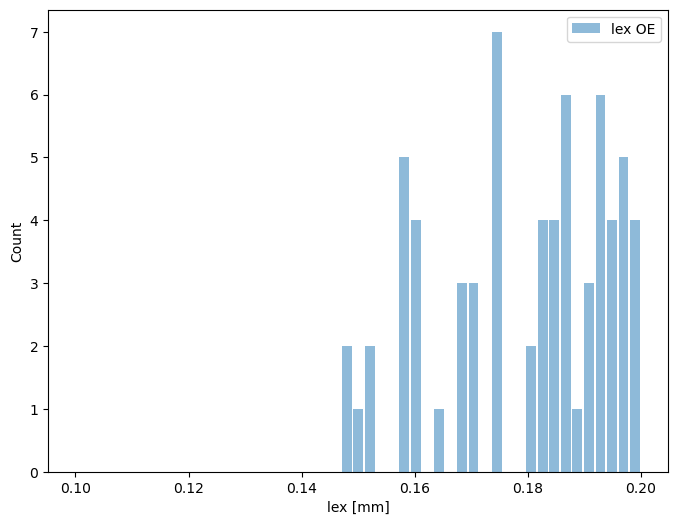

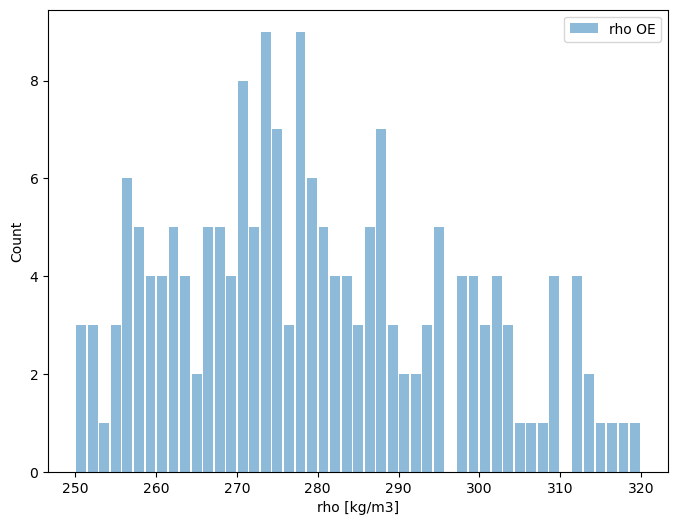

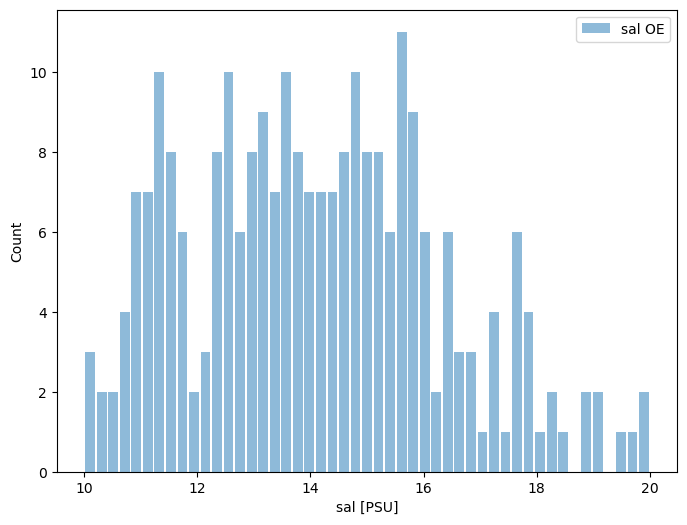

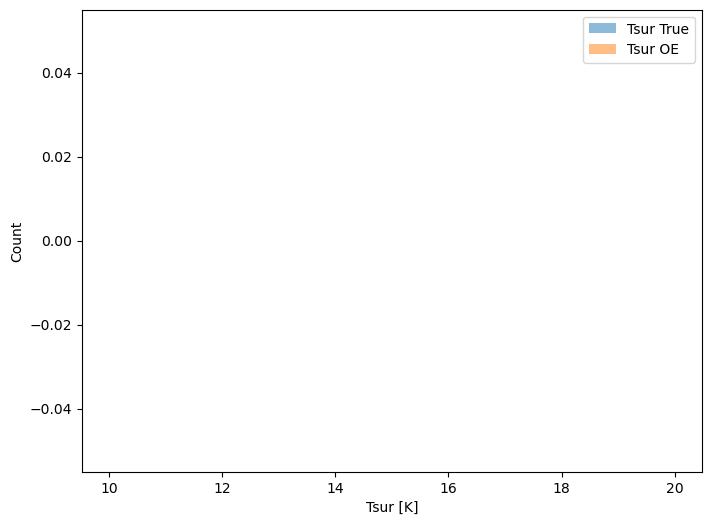

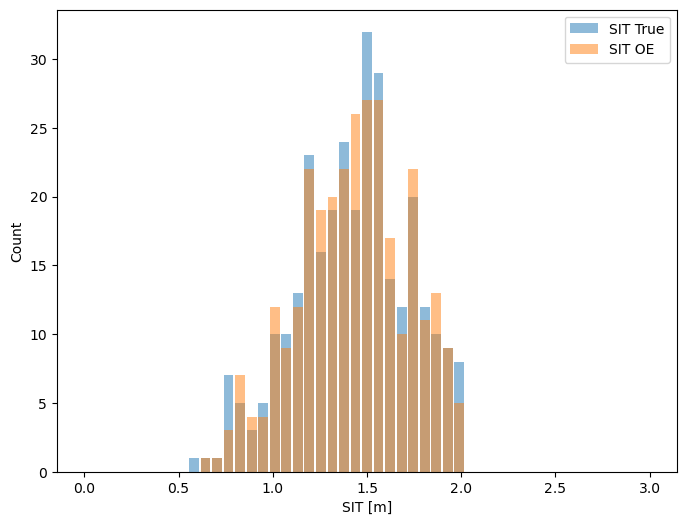

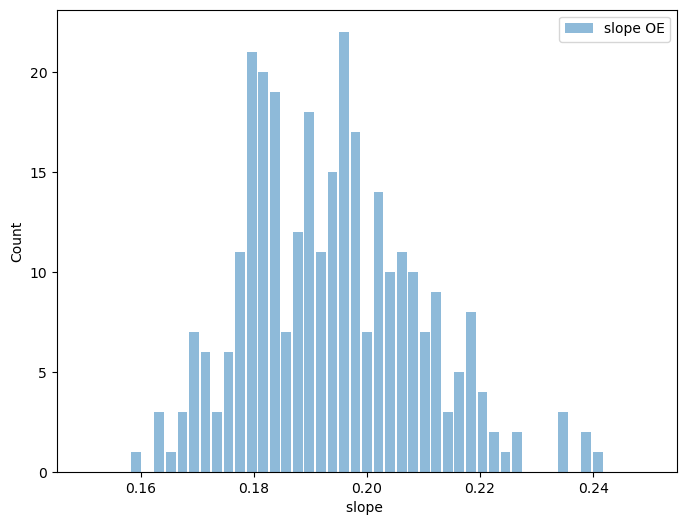

In [17]:
def hist_idv(variables, OIB_data, nn):

   
    for var, data in zip(variables, OIB_data): 
        OE = []
        OIB = []
        #set limits
        try:
            for x_optim, n in zip(x_optimals, nn):
                    OE.append(x_optim[var])
                    OIB.append(data[n])
        except:
            pass
            # print('convergence was not reached at: ', x_optim)
        
        if var=='SD':
            OE = 10**np.array(OE)
            bins = np.linspace(0, 0.35, 50)
            unit = ' [m]'
        elif var=='sal':
            OE = np.array(OE)*1e3
            OIB = np.array(OIB)*1e3
            bins = np.linspace(10, 20, 50)
            unit = ' [PSU]'
        elif var=='rho':
            bins = np.linspace(250, 320, 50)
            unit = ' [kg/m3]'
        elif var=='lex':
            OE = 10**np.array(OE)*1e3
            OIB = np.array(OIB)*1e3
            bins = np.linspace(0.1, 0.2, 50)
            unit = ' [mm]'
        elif var=='Tsur':
            unit = ' [K]'
        elif var=='SIT':
            bins = np.linspace(0, 3, 50)
            unit = ' [m]'
        elif var=='slope':
            bins = np.linspace(0.15, 0.25, 50)
            unit = ' '
        plt.figure(figsize=(8,6))
        if var!='sal' and var!='rho' and var!='lex' and var!='slope':
            plt.hist(OIB, bins=bins,alpha=0.5,rwidth=0.85, label = var + ' True')
        plt.hist(OE, bins=bins, alpha=0.5,rwidth=0.85, label = var + ' OE')
        plt.legend(loc='upper right')
        plt.xlabel(var + unit)
        # plt.grid()
        plt.ylabel('Count')
        plt.savefig(savepath + var + '_hist_idv_slope_covx2.png',bbox_inches='tight')
        plt.show()




# take nn of each
OIB_data_plot = []
print(input_variables)
if 'SD' in input_variables:
    if logarithmic==True:
        OIB_data_plot.append(10**FYI_data.sd)
    else:
        OIB_data_plot.append(FYI_data.sd)
if 'lex' in input_variables:
    if logarithmic==True:
        OIB_data_plot.append(10**FYI_data.sd_lex)
    else:
        OIB_data_plot.append(FYI_data.sd_lex)
if 'rho' in input_variables:
    OIB_data_plot.append(FYI_data.sd_rho)
    
if 'sal' in input_variables:
    #if logarithmic==True:
    #    OIB_data_plot.append(10**FYI_data.sd_sal)
    #else:
    OIB_data_plot.append(FYI_data.sd_sal)
if 'Tsur' in input_variables:
    #if logarithmic==True:
    #    OIB_data_plot.append(10**FYI_data.sd_sal)
    #else:
    OIB_data_plot.append(FYI_data.skt)
if 'SIT' in input_variables:
    OIB_data_plot.append(FYI_data.sit)
if 'slope' in input_variables:
    OIB_data_plot.append(FYI_data.OIB_surf_rough)
BD = hist_idv(input_variables, OIB_data_plot, nn)

In [ ]:
# nn = [i for i in range(ns)]
nn  = np.array(nn, dtype=int)
nnn = np.delete(nn, no)
no  = np.array(np.unique(no), dtype=int)

fig, ax = plt.subplots(3, figsize=(7,10), sharex=False)

vars = ['SD', 'SIT', 'Tsur']
xlabel = ['m', 'm','K']
xlim = [[0,0.4], [0,3], [240, 270]]
binss = [np.linspace(0, 1, 50), np.linspace(0, 5, 100), np.linspace(230, 270, 50)]
# bins = 
for var, i in zip([10**FYI_data.sd, FYI_data.sit, FYI_data.skt], range(3)):
    bins = binss[i]
    ax[i].hist(var[nnn], bins=bins, rwidth=0.85, alpha=0.5, label = 'converged, ' + str(len(nnn)))
    ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged, ' + str(len(no)))
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
    
plt.legend(bbox_to_anchor=(1.35, 3.3))
plt.savefig(savepath + str(slope_std) +'_hist.png', bbox_inches='tight')

In [ ]:
import math
# nn = [i for i in range(ns)]
nn  = np.array(nn, dtype=int)
nnn = nn # np.delete(nn, no)
# no  = np.array(np.unique(no), dtype=int)

SD_OE = [10**oe.x_op[0] for oe in np.array(oe_out)[nnn]]
rho_OE = [oe.x_op[1] for oe in np.array(oe_out)[nnn]]
sal_OE = [oe.x_op[2] for oe in np.array(oe_out)[nnn]]
slope_OE = [oe.x_op[3] for oe in np.array(oe_out)[nnn]]
# tsk_OE = [oe.x_op[4] for oe in np.array(oe_out)[nnn]]


vars = ['SD', 'rho', 'sal', ' slope']
xlabel = ['m', 'kg/m3', '', '']
xlim = [[0,0.4], [150, 450], [5/1000,20/1000],[0.05, 0.5]]
binss = [np.linspace(0, 1, 100), np.linspace(200, 400, 100),
         np.linspace(0, 20/1000, 100),
         np.linspace(0.1, 0.4, 100)]

std_diag = np.sqrt(np.diag(x_cov))
std_diag[0] = 10**std_diag[0]
#std_array = np.sqrt(np.diag(x_cov))
#oe_out
fig, ax = plt.subplots(4, figsize=(7,10), sharex=False)
for var, i in zip([SD_OE, rho_OE, sal_OE, slope_OE], range(4)):
    bins = binss[i]
    ax[i].hist(np.array(var), bins=bins, rwidth=0.85, alpha=0.5)
    # ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged, ' + str(len(no)))
    ax[i].axvline(np.array(var).mean(), color='r', linestyle='dashed', linewidth=1)
    ## the "input cov std"
    ax[i].axvline(np.array(var).mean()-std_diag[i], color='k', linestyle='dashed', linewidth=1)
    ax[i].axvline(np.array(var).mean()+std_diag[i], color='k', linestyle='dashed', linewidth=1)
    ## the real std
    ax[i].axvline(np.array(var).mean()-np.array(var).std(), color='r', linestyle='dashed', linewidth=1)
    ax[i].axvline(np.array(var).mean()+np.array(var).std(), color='r', linestyle='dashed', linewidth=1)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
    
#plt.legend(bbox_to_anchor=(1.35, 3.3))
plt.savefig(savepath + str(slope_std) +'_variables_distribution_hist.png', bbox_inches='tight')

In [ ]:
SD_OE

In [ ]:
## degrees of freedom
rel = np.array(oe_out)[nnn]
df = [r.dgf for r in rel]
plt.figure(figsize=(6,6))
plt.scatter(nnn, df)
plt.grid()
plt.title('Degrees of freedom')
plt.xlabel('point')
plt.ylabel('dgf')
plt.ylim(0,4)
plt.savefig(savepath + '_degrees of freedom.png' )
plt.show()

In [ ]:
#rel = np.array(oe_out)[BD.astype(int)]
rel = np.array(oe_out)[nnn][BD.astype(int)]

oe_comb = np.mean([r.S_op for r in rel], axis=0)
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe_comb, oe_show.S_a, name='bad_out')



In [ ]:
#rel = np.array(oe_out)[BD.astype(int)]
good = np.delete(nnn, BD.astype(int))
rel = np.array(oe_out)[good]

oe_comb = np.mean([r.S_op for r in rel], axis=0)
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe_comb, oe_show.S_a, name='good_out')



In [ ]:
FYI_data.lat[BD]
FYI_data.lon[BD]
FYI_data.date[BD]

In [ ]:
FYI_data.date[nn[:-1]]

In [ ]:
FYI_data.date[no]

In [ ]:
from polar_plots_pred import polar_plot as pp

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)

FYI_data_plot.lat = FYI_data.lat[no] 
FYI_data_plot.lon = FYI_data.lon[no]
FYI_data_plot.sit = FYI_data.sit[no]
title= 'not converged'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=20)

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)

FYI_data_plot.lat = FYI_data.lat[nn[:-1]] 
FYI_data_plot.lon = FYI_data.lon[nn[:-1]]
FYI_data_plot.sit = FYI_data.sit[nn[:-1]]
title= 'Converged'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=7)

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)
FYI_data_plot.lat = FYI_data.lat[BD] 
FYI_data_plot.lon = FYI_data.lon[BD]
FYI_data_plot.sit = FYI_data.sit[BD]
title= 'RMSE Large'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=8)